# Painters Identification using ConvNets
<img align="right" width="350" height="350"
     title="Size Limit logo" src="pooling.png">
### Index

- [Introduction](#intro)
- [Overview and Data](#over)
    - [Importing packages](#pack)
- [Organizing and preprocessing the data](#orgdata)
    - [Building subfolders](#splitting)
    - [Preprocessing data](#prepro)
    - [Folders containing train and test sets](#ttsets)
    - [Building subdirectory per image class](#buildsubs)

## Introduction

The challenge of recognizing artists given their paintings has been, for a long time, far beyond the capability of algorithms. Recent advances in deep learning, specifically the development of convolutional neural networks, have made that task possible.

## Overview and Data 

I used Convolutional Neural Networks (ConvNets) to identify the artist of a given painting. 

The dataset contains a minimum of 400 paintings per artist <br> from a set of 37 famous artists. 
<br><br>
I trained a small ConvNet built from scratch, and also used transfer learning, fine-tuning the top layers of a deep pre-trained networks (VGG16).

The file `all_data_info.csv` contains information about the images. Only three columns were kept. The titles of the first and third columns are self-evident. A general observation regarding image sets is that we can say that "each image is a (or is a set of) features". Images can be also interpreted as array of numbers (more on that later).

In [53]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # see the value of multiple statements at once.
pd.set_option('display.max_columns', None)

In [54]:
df = pd.read_csv('all_data_info.csv').iloc[:, [0,10,11]]
df.head()
print("The number of rows in our dataframe is:",df.shape[0],'\n')

,artist,in_train,new_filename
0,Barnett Newman,True,102257.jpg
1,Barnett Newman,True,75232.jpg
2,kiri nichol,False,32145.jpg
3,kiri nichol,False,20304.jpg
4,kiri nichol,False,836.jpg


The number of rows in our dataframe is: 103250 



In [58]:
len([x for x in df['new_filename'].duplicated(keep=False) if x == True])

0

In [60]:
af.vc_to_df(df['artist'].value_counts())

,value_counts
col_name,
Giovanni Battista Piranesi,500
Ivan Shishkin,500
John Singer Sargent,500
Pierre-Auguste Renoir,500
Pablo Picasso,500
Marc Chagall,500
Zdislav Beksinski,500
Ilya Repin,500
Rembrandt,500


## Importing packages

Some useful packages are:

- `cv2` which is used for working with images e.g. for resizing 
- `os` which is used to work with directories
- `tqdm` which shows a percentage bar for tasks
- `PIL` (Python Imaging Library) which is used for opening/manipulating/saving image files

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import aux_func as af # the library contains useful auxiliar functions
%matplotlib inline

from PIL import Image, ImageFilter
import random
import cv2, os
seed = 42
np.random.seed(seed)
from tqdm import tqdm

#### Are there null values?

From below we see that there are no null values in `df`.

In [4]:
# The function `vc_to_df` converts the value_counts Series into a DataFrame
af.vc_to_df(df.isnull().any())   

,value_counts
col_name,
artist,False
in_train,False
new_filename,False


In the next cell I do the following steps:
- Split the dataframe into train and test dataframes using the column `in_train`
- Drop the `in_train` column from the `train` and `test` dataframes

## Choosing artists with a minimum number of paintings 

In [31]:
# The function threshold keeps only artists with minimum number of painters
minimum = 400 
df = af.threshold(df,'artist',minimum)
df.head()
print("1) There are {}".format(df['artist'].nunique()),
      'painters with {} or more paintings\n'.format(minimum))
print('2) The artists are with {} or more paintings are:\n'.format(minimum))
artists = list(df['artist'].value_counts().index)
print(artists,'\n')
df_new = df[df['artist'].isin(artists)]   # another way to build the new df
print('The number of rows (i.e. the number of paintings) in the reduced dataset is now', df_new.shape[0])

,artist,in_train,new_filename
14,Ivan Aivazovsky,True,99442.jpg
28,Gustave Dore,True,7486.jpg
29,Gustave Dore,True,35766.jpg
34,Gustave Dore,False,31977.jpg
54,Odilon Redon,True,29331.jpg


1) There are 37 painters with 400 or more paintings

2) The artists are with 400 or more paintings are:

['John Singer Sargent', 'Ivan Shishkin', 'Marc Chagall', 'Gustave Dore', 'Rembrandt', 'Albrecht Durer', 'Pablo Picasso', 'Ilya Repin', 'Giovanni Battista Piranesi', 'Ivan Aivazovsky', 'Pierre-Auguste Renoir', 'Zdislav Beksinski', 'Pyotr Konchalovsky', 'Camille Pissarro', 'Martiros Saryan', 'Paul Cezanne', 'Claude Monet', 'Boris Kustodiev', 'Paul Gauguin', 'Raphael Kirchner', 'Nicholas Roerich', 'Eugene Boudin', 'Edgar Degas', 'Henri Matisse', 'Vincent van Gogh', 'Childe Hassam', 'Camille Corot', 'Theophile Steinlen', 'Salvador Dali', 'Alfred Sisley', 'Odilon Redon', 'Isaac Levitan', 'Fernand Leger', 'James Tissot', 'Eyvind Earle', 'Zinaida Serebriakova', 'Henri Martin'] 

The number of rows (i.e. the number of paintings) in the reduced dataset is now 17881


### Separating the dataset into training and testing sets

In [81]:
train = df_new[df_new['in_train'] == True].drop(['in_train'],axis=1)
print('The number of rows in the training set is:',train.shape[0],'\n')
print('The number of paintings per painter in the training set is:\n')
af.vc_to_df(train['artist'].value_counts())
test = df_new[df_new['in_train'] == False].drop(['in_train'],axis=1)
print('The number of rows in the testing set is:',test.shape[0],'\n')
print('The number of paintings per painter in the testing set is:\n')
af.vc_to_df(test['artist'].value_counts())

print('The ratio of rows in the training and testing sets is approximately',
      int(round(100*train.shape[0]/df.shape[0],0)),
      ':',int(round(100*test.shape[0]/df.shape[0],0)))

The number of rows in the training set is: 13691 

The number of paintings per painter in the training set is:



,value_counts
col_name,
Paul Cezanne,412
Giovanni Battista Piranesi,402
Martiros Saryan,399
Ilya Repin,397
Camille Pissarro,393
Vincent van Gogh,392
Theophile Steinlen,389
Pyotr Konchalovsky,388
Pierre-Auguste Renoir,388


The number of rows in the testing set is: 4190 

The number of paintings per painter in the testing set is:



,value_counts
col_name,
Raphael Kirchner,140
Salvador Dali,137
Marc Chagall,133
Ivan Shishkin,133
Isaac Levitan,128
Nicholas Roerich,127
Paul Gauguin,125
Zdislav Beksinski,124
Rembrandt,124


The ratio of rows in the training and testing sets is approximately 13 : 4



### Organizing and preprocessing the data

There are two steps here:
- The images from Wikiart had a extremely large number of pixels so I wrote a simple function `preprocess( )` to resize the images. Furthermore, I believe that the style of the painter is present everywhere in the painting, so cropping shouldn't cause major problems.
- The training and testing files were in two separate folders. I created, within each of these two folders, sub-folders corresponding to each painter. This was done to prepare the date in the shape required by the ConvNet model (more on this later)

#### Side note

First, a few comments regarding the use of the `os` library and `PIL` package:
- `os.path.join` constructs a pathname out of partial pathnames
- `os.path.abspath` transforms a general pathname into a full pathname. 
- `os.listdir(PATH)` returns a list containing the names of the files in the directory given by PATH.
- `Image.open` converts a string (a path in this case) into a PIL image:

      /Users/marcotavora/capstone_phase_2/trainsetnew/1.jpg --> PIL.JpegImagePlugin.JpegImageFile

#### Location of the files

The training data, without splitting into sub-folders was located at the directory:

    /Users/marcotavora/capstone_phase_2/trainsetnew. 
    
The testing data was in:

    /Users/marcotavora/capstone_phase_2/testsetnew 
   

In [82]:
PATH = os.path.abspath('./trainsetnew')
PATHTEST = os.path.abspath('./testsetnew')
print('The training data is in the folder:',PATH)
print('The testing data is in the folder:',PATHTEST)

The training data is in the folder: /Users/marcotavora/capstone_phase_2/trainsetnew
The testing data is in the folder: /Users/marcotavora/capstone_phase_2/testsetnew


### Image resizing

The `preprocess` function below reads files from one folder (i.e. one path), resizes them (keeping images in RGB) and copy them into another folder. A few commentaries about the function:
- It would stop when finding a file that, if unpacked, would lead to a "decompression bomb". The first line of the function prevents that from happening.
- The `for` will loop over the images file names contained in the list of files with names `os.listdir(PATH)`. For example for the original training set this is:

        os.listdir(PATHTRAIN) = ['1.jpg', '10.jpg',...]
        
- `Image.open` opens the image.

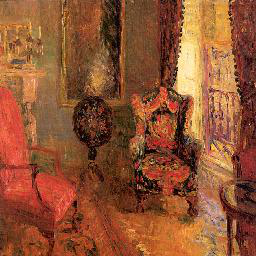

In [34]:
Image.open('/Users/marcotavora/capstone_phase_2/trainsetnew/70.jpg')

- Then `img.resize` will resize the images into the dimension we choose
- To save the new image into another "dump" folder I use

        .save(os.path.join(PATHDUMP, image_filename))
    
- The `try` and `except` is used to control for images that cannot be resized
- Before resizing the files, we must first create the new directory to which the resized images will be sent using:

        #%mkdir new_directory

In [ ]:
# def preprocess(size,PATH,PATHDUMP):
#     Image.MAX_IMAGE_PIXELS = None  
#     for image_filename in tqdm(os.listdir(PATH)):
#         img = Image.open(os.path.join(PATH, 
#                                       image_filename))                       
#         try:
#             img.resize((size, size))\
#             .convert('RGB')\
#             .save(os.path.join(PATHDUMP, 
#                                image_filename))
#         except Exception as e:
#             print("Unable to process {}".format(image_filename))
#             print(e)

- Defining the variables containing the original path and the path that will contain the resized images as. Suppose the file containing the images we want to resize is called `./train_9` and we want to dump the resized images into `./trainnew_9`. The path names are:

        PATH = os.path.abspath('./train_9') = '/Users/marcotavora/capstone_phase_2/train_9'
        PATHDUMP = os.path.abspath('./trainnew_9') = '/Users/marcotavora/capstone_phase_2/trainnew_9'
    
- If we want to resize the images into 256 by 256 pixels we run:

        preprocess(256,PATH,PATHDUMP)

- The next step is to move the resized files inside `/Users/marcotavora/capstone_phase_2/trainnew_9` into the folder `trainsetnew/` containing the rest of the training set:

        #!mv trainnew_9/* trainsetnew/
   
### Comparing painters in training and testing sets

We can check if the painters in the train and test sets are the same:

In [83]:
print('Are the same painters in both sets:',
      sorted(list(train['artist'].unique())) == sorted(list(test['artist'].unique())),'\n')
print('Painters in the training set:\n',sorted(list(train['artist'].unique())),'\n')
print('Painters in the test set:\n',sorted(list(test['artist'].unique())),'\n')
len(sorted(list(train['artist'].unique())))

Are the same painters in both sets: True 

Painters in the training set:
 ['Albrecht Durer', 'Alfred Sisley', 'Boris Kustodiev', 'Camille Corot', 'Camille Pissarro', 'Childe Hassam', 'Claude Monet', 'Edgar Degas', 'Eugene Boudin', 'Eyvind Earle', 'Fernand Leger', 'Giovanni Battista Piranesi', 'Gustave Dore', 'Henri Martin', 'Henri Matisse', 'Ilya Repin', 'Isaac Levitan', 'Ivan Aivazovsky', 'Ivan Shishkin', 'James Tissot', 'John Singer Sargent', 'Marc Chagall', 'Martiros Saryan', 'Nicholas Roerich', 'Odilon Redon', 'Pablo Picasso', 'Paul Cezanne', 'Paul Gauguin', 'Pierre-Auguste Renoir', 'Pyotr Konchalovsky', 'Raphael Kirchner', 'Rembrandt', 'Salvador Dali', 'Theophile Steinlen', 'Vincent van Gogh', 'Zdislav Beksinski', 'Zinaida Serebriakova'] 

Painters in the test set:
 ['Albrecht Durer', 'Alfred Sisley', 'Boris Kustodiev', 'Camille Corot', 'Camille Pissarro', 'Childe Hassam', 'Claude Monet', 'Edgar Degas', 'Eugene Boudin', 'Eyvind Earle', 'Fernand Leger', 'Giovanni Battista Piranesi'

37

### Filtering train and test folders

- I will create training and testing folders containing only images present in the dataframe (to check for mistakes in the dataframe versus the images in the folders). I will first created two new empty folders:

        %mkdir './train_400'
        %mkdir './test_400'
        
- The following lists contain the name of the paintings in the training and testing sets:

In [33]:
#%mkdir './train_400'
#%mkdir './test_400'

In [84]:
train_painting_list = list(train['new_filename'])
test_painting_list = list(test['new_filename'])
len(train_painting_list)
len(test_painting_list)

13691

4190

- The following function creates the folders with the restricted set of painters:

In [89]:
def filtered_folder_maker(PATH,PATHDUMP,lst):
    for image_filename in tqdm(os.listdir(PATH)[1:]):
        img = Image.open(os.path.join(PATH,image_filename))  
        if image_filename in lst:
            try:
                img.save(os.path.join(PATHDUMP,image_filename)) 
            except Exception as e:
                print("Unable to transfer {}".format(image_filename))
                print(e)

In [51]:
# 74969.jpg has no size so I manually excluded it
#PATH = os.path.abspath('./trainsetnew')
#PATHDUMP = os.path.abspath('./train_400')
#filtered_folder_maker(PATH,PATHDUMP,train_painting_list)

100%|██████████| 79447/79447 [03:54<00:00, 339.46it/s]


In [18]:
#PATHTEST = os.path.abspath('./testsetnew')
#PATHDUMPTEST = os.path.abspath('./test_400')
#filtered_folder_maker(PATHTEST,PATHDUMPTEST,test_painting_list)

100%|██████████| 23813/23813 [00:56<00:00, 419.67it/s]


#### Checking lengths (for sanity)  PROBLEM

In [86]:
len(os.listdir(os.path.abspath('./train_400'))),len(train_painting_list)

(13690, 13691)

In [87]:
train_painting_list = [x for x in train_painting_list if x in os.listdir(os.path.abspath('./train_400'))]

In [88]:
len(os.listdir(os.path.abspath('./train_400'))),len(train_painting_list)

(13690, 13690)

In [77]:
len(os.listdir(os.path.abspath('./test_400'))),len(test_painting_list)

(4190, 4190)

#### Quick summary of the present state of files:

In [78]:
print('Shape of training set :',train.shape)
print('Shape of testing set:',test.shape)
print('Number of files in the training folder:',
      len(os.listdir(os.path.abspath('./train_400'))))
print('Number of files in the test folder:',
      len(os.listdir(os.path.abspath('./test_400'))))
print("")
print("Are the names of the files the same in the train and test dataframes and the folders?")
sorted(list(train['new_filename'])) == sorted(os.listdir(os.path.abspath('./train_400')))
sorted(list(test['new_filename'])) == sorted(os.listdir(os.path.abspath('./test_400')))

Shape of training set : (13691, 2)
Shape of testing set: (4190, 2)
Number of files in the training folder: 13690
Number of files in the test folder: 4190

Are the names of the files the same in the train and test dataframes and the folders?


False

True

#### Creating list with the name of the painters:

In [63]:
painters = list(train['artist'].unique())
print(painters)
len(painters)

['Ivan Aivazovsky', 'Gustave Dore', 'Odilon Redon', 'Rembrandt', 'Edgar Degas', 'Claude Monet', 'Albrecht Durer', 'Theophile Steinlen', 'Ivan Shishkin', 'Giovanni Battista Piranesi', 'Camille Corot', 'Pierre-Auguste Renoir', 'Childe Hassam', 'Raphael Kirchner', 'James Tissot', 'Alfred Sisley', 'Paul Cezanne', 'John Singer Sargent', 'Vincent van Gogh', 'Zdislav Beksinski', 'Camille Pissarro', 'Eugene Boudin', 'Fernand Leger', 'Boris Kustodiev', 'Nicholas Roerich', 'Ilya Repin', 'Martiros Saryan', 'Isaac Levitan', 'Pyotr Konchalovsky', 'Salvador Dali', 'Pablo Picasso', 'Henri Matisse', 'Henri Martin', 'Marc Chagall', 'Paul Gauguin', 'Eyvind Earle', 'Zinaida Serebriakova']


37


### Building subfolders

To create the subfolders we must use the information dataframe to split the the images by painters. 

#### Building a list of sublists of painters 

The lists below contain a set of sublists and each of these sublists contains paintings by one painter only. Regarding the syntax:
- The list `painters` is a list of all painters that were kept in the dataframe
- The sublist `list(train_2[train_2['artist'] == i]['new_filename'])` contain all paintings by painter `i`
- The lists `lst_train` and `lst_test` concatenate all sublists

In [94]:
train_2 = train.copy()  # for safety reasons
test_2 = test.copy()
lst_train = []
for i in painters:
    lst_train.append(list(train_2[train_2['artist'] == i]['new_filename']))

lst_test = []
for i in painters:
    lst_test.append(list(test_2[test_2['artist'] == i]['new_filename']))

Quick test of the syntax:

In [65]:
i,j,k = painters[0],painters[1],painters[11]   # Ivan Aivazovsky, Gustave Dore and Gustave Dore
train_2[train_2['artist'] == i].head()
list(train_2[train_2['artist'] == i]['new_filename'])[0:5]
train_2[train_2['artist'] == j].head()
list(train_2[train_2['artist'] == j]['new_filename'])[0:5]
train_2[train_2['artist'] == k].head()
list(train_2[train_2['artist'] == k]['new_filename'])[0:5]

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
82,Ivan Aivazovsky,81750.jpg
660,Ivan Aivazovsky,82140.jpg
798,Ivan Aivazovsky,74871.jpg
7030,Ivan Aivazovsky,51238.jpg


['99442.jpg', '81750.jpg', '82140.jpg', '74871.jpg', '51238.jpg']

,artist,new_filename
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
1747,Gustave Dore,94058.jpg
3333,Gustave Dore,63458.jpg
3557,Gustave Dore,37956.jpg


['7486.jpg', '35766.jpg', '94058.jpg', '63458.jpg', '37956.jpg']

,artist,new_filename
711,Pierre-Auguste Renoir,3016.jpg
1892,Pierre-Auguste Renoir,3603.jpg
3482,Pierre-Auguste Renoir,82624.jpg
4280,Pierre-Auguste Renoir,25088.jpg
4346,Pierre-Auguste Renoir,51077.jpg


['3016.jpg', '3603.jpg', '82624.jpg', '25088.jpg', '51077.jpg']

In [66]:
print(lst_train[0][0:5]) # sublist containing paintings by painter[0]
print(lst_train[1][0:5]) # sublist containing paintings by painter[1]
print(lst_train[2][0:5]) # sublist containing paintings by painter[2]
print(lst_train[11][0:5]) # sublist containing paintings by painter[11]

['99442.jpg', '81750.jpg', '82140.jpg', '74871.jpg', '51238.jpg']
['7486.jpg', '35766.jpg', '94058.jpg', '63458.jpg', '37956.jpg']
['29331.jpg', '78766.jpg', '25287.jpg', '48925.jpg', '89927.jpg']
['3016.jpg', '3603.jpg', '82624.jpg', '25088.jpg', '51077.jpg']


We must first create the directories that will contain the individual painters' sub-folders.

In [ ]:
# %mkdir './trainsetnewsplit'
# %mkdir './testsetnewsplit'

The auxiliary functions below just write out the commands:

    %mkdir './trainsetnewsplit/Ivan_Aivazovsky'
    %mkdir './trainsetnewsplit/Gustave_Dore'
    %mkdir './trainsetnewsplit/Rembrandt'
    ...

In [107]:
def list_folder_train(lst):
    lst_sub_folders = []
    for i in range(len(lst)):
        lst_sub_folders.append('%mkdir'+' '+"'./trainsetnewsplit_400/"+ painters[i] + "'")
    return lst_sub_folders

def list_folder_test(lst):
    lst_sub_folders = []
    for i in range(len(lst)):
        lst_sub_folders.append('%mkdir'+' '+"'./testsetnewsplit_400/"+ painters[i] + "'")
    return lst_sub_folders

In [97]:
len(painters)
len(lst_train)

37

37

In [108]:
list_folder_train(lst_train)[0]

"%mkdir './trainsetnewsplit_400/Ivan Aivazovsky'"

In [98]:
%mkdir './trainsetnewsplit_400'
%mkdir './testsetnewsplit_400'

In [109]:
for el in list_folder_train(lst_train):
    print(el.replace(' ','_').replace('dir_','dir '))
for el in list_folder_test(lst_test):
    print(el.replace(' ','_').replace('dir_','dir '))

%mkdir './trainsetnewsplit_400/Ivan_Aivazovsky'
%mkdir './trainsetnewsplit_400/Gustave_Dore'
%mkdir './trainsetnewsplit_400/Odilon_Redon'
%mkdir './trainsetnewsplit_400/Rembrandt'
%mkdir './trainsetnewsplit_400/Edgar_Degas'
%mkdir './trainsetnewsplit_400/Claude_Monet'
%mkdir './trainsetnewsplit_400/Albrecht_Durer'
%mkdir './trainsetnewsplit_400/Theophile_Steinlen'
%mkdir './trainsetnewsplit_400/Ivan_Shishkin'
%mkdir './trainsetnewsplit_400/Giovanni_Battista_Piranesi'
%mkdir './trainsetnewsplit_400/Camille_Corot'
%mkdir './trainsetnewsplit_400/Pierre-Auguste_Renoir'
%mkdir './trainsetnewsplit_400/Childe_Hassam'
%mkdir './trainsetnewsplit_400/Raphael_Kirchner'
%mkdir './trainsetnewsplit_400/James_Tissot'
%mkdir './trainsetnewsplit_400/Alfred_Sisley'
%mkdir './trainsetnewsplit_400/Paul_Cezanne'
%mkdir './trainsetnewsplit_400/John_Singer_Sargent'
%mkdir './trainsetnewsplit_400/Vincent_van_Gogh'
%mkdir './trainsetnewsplit_400/Zdislav_Beksinski'
%mkdir './trainsetnewsplit_400/Camille_Pissarr

Creating all directories:

In [110]:
%mkdir './trainsetnewsplit_400/Ivan_Aivazovsky'
%mkdir './trainsetnewsplit_400/Gustave_Dore'
%mkdir './trainsetnewsplit_400/Odilon_Redon'
%mkdir './trainsetnewsplit_400/Rembrandt'
%mkdir './trainsetnewsplit_400/Edgar_Degas'
%mkdir './trainsetnewsplit_400/Claude_Monet'
%mkdir './trainsetnewsplit_400/Albrecht_Durer'
%mkdir './trainsetnewsplit_400/Theophile_Steinlen'
%mkdir './trainsetnewsplit_400/Ivan_Shishkin'
%mkdir './trainsetnewsplit_400/Giovanni_Battista_Piranesi'
%mkdir './trainsetnewsplit_400/Camille_Corot'
%mkdir './trainsetnewsplit_400/Pierre-Auguste_Renoir'
%mkdir './trainsetnewsplit_400/Childe_Hassam'
%mkdir './trainsetnewsplit_400/Raphael_Kirchner'
%mkdir './trainsetnewsplit_400/James_Tissot'
%mkdir './trainsetnewsplit_400/Alfred_Sisley'
%mkdir './trainsetnewsplit_400/Paul_Cezanne'
%mkdir './trainsetnewsplit_400/John_Singer_Sargent'
%mkdir './trainsetnewsplit_400/Vincent_van_Gogh'
%mkdir './trainsetnewsplit_400/Zdislav_Beksinski'
%mkdir './trainsetnewsplit_400/Camille_Pissarro'
%mkdir './trainsetnewsplit_400/Eugene_Boudin'
%mkdir './trainsetnewsplit_400/Fernand_Leger'
%mkdir './trainsetnewsplit_400/Boris_Kustodiev'
%mkdir './trainsetnewsplit_400/Nicholas_Roerich'
%mkdir './trainsetnewsplit_400/Ilya_Repin'
%mkdir './trainsetnewsplit_400/Martiros_Saryan'
%mkdir './trainsetnewsplit_400/Isaac_Levitan'
%mkdir './trainsetnewsplit_400/Pyotr_Konchalovsky'
%mkdir './trainsetnewsplit_400/Salvador_Dali'
%mkdir './trainsetnewsplit_400/Pablo_Picasso'
%mkdir './trainsetnewsplit_400/Henri_Matisse'
%mkdir './trainsetnewsplit_400/Henri_Martin'
%mkdir './trainsetnewsplit_400/Marc_Chagall'
%mkdir './trainsetnewsplit_400/Paul_Gauguin'
%mkdir './trainsetnewsplit_400/Eyvind_Earle'
%mkdir './trainsetnewsplit_400/Zinaida_Serebriakova'
%mkdir './testsetnewsplit_400/Ivan_Aivazovsky'
%mkdir './testsetnewsplit_400/Gustave_Dore'
%mkdir './testsetnewsplit_400/Odilon_Redon'
%mkdir './testsetnewsplit_400/Rembrandt'
%mkdir './testsetnewsplit_400/Edgar_Degas'
%mkdir './testsetnewsplit_400/Claude_Monet'
%mkdir './testsetnewsplit_400/Albrecht_Durer'
%mkdir './testsetnewsplit_400/Theophile_Steinlen'
%mkdir './testsetnewsplit_400/Ivan_Shishkin'
%mkdir './testsetnewsplit_400/Giovanni_Battista_Piranesi'
%mkdir './testsetnewsplit_400/Camille_Corot'
%mkdir './testsetnewsplit_400/Pierre-Auguste_Renoir'
%mkdir './testsetnewsplit_400/Childe_Hassam'
%mkdir './testsetnewsplit_400/Raphael_Kirchner'
%mkdir './testsetnewsplit_400/James_Tissot'
%mkdir './testsetnewsplit_400/Alfred_Sisley'
%mkdir './testsetnewsplit_400/Paul_Cezanne'
%mkdir './testsetnewsplit_400/John_Singer_Sargent'
%mkdir './testsetnewsplit_400/Vincent_van_Gogh'
%mkdir './testsetnewsplit_400/Zdislav_Beksinski'
%mkdir './testsetnewsplit_400/Camille_Pissarro'
%mkdir './testsetnewsplit_400/Eugene_Boudin'
%mkdir './testsetnewsplit_400/Fernand_Leger'
%mkdir './testsetnewsplit_400/Boris_Kustodiev'
%mkdir './testsetnewsplit_400/Nicholas_Roerich'
%mkdir './testsetnewsplit_400/Ilya_Repin'
%mkdir './testsetnewsplit_400/Martiros_Saryan'
%mkdir './testsetnewsplit_400/Isaac_Levitan'
%mkdir './testsetnewsplit_400/Pyotr_Konchalovsky'
%mkdir './testsetnewsplit_400/Salvador_Dali'
%mkdir './testsetnewsplit_400/Pablo_Picasso'
%mkdir './testsetnewsplit_400/Henri_Matisse'
%mkdir './testsetnewsplit_400/Henri_Martin'
%mkdir './testsetnewsplit_400/Marc_Chagall'
%mkdir './testsetnewsplit_400/Paul_Gauguin'
%mkdir './testsetnewsplit_400/Eyvind_Earle'
%mkdir './testsetnewsplit_400/Zinaida_Serebriakova'

#### Function `subfolder_maker_multi(  )`  logic

The function must do the following (take the `lst_train` for illustration):
- Fixes a `sublist` inside `lst`, say, `lst[0]` (i.e. fix a painter, say, Ivan Aivazovsky)
- Fixes an element inside the `sublist` 
- Build paths of the form below for each element `i` of the sublist

      ./trainsetnewsplit/Ivan_Aivazovsky/sublist[i]
      
- Save `lst_train[0][i]` for all `i` within the sublist to that subfolder

In [111]:
def subfolder_maker_multi(PATH,PATHDUMP,lst):
    for sublist in tqdm(lst): # fix a sublist, 
        for el in sublist:   
            img = Image.open(os.path.join(PATH,el))  # creates PIL image 
            img.save(os.path.join(PATHDUMP,
                                  painters[lst.index(sublist)].replace(' ','_'),el))

#### Applying the the full list

In [112]:
PATH = os.path.abspath('./train_400')
PATHDUMP = os.path.abspath('./trainsetnewsplit_400')
PATH
PATHDUMP

'/Users/marcotavora/capstone_phase_2/train_400'

'/Users/marcotavora/capstone_phase_2/trainsetnewsplit_400'

In [ ]:
!rm '/Users/marcotavora/capstone_phase_2/trainsetnewsplit_400'

In [114]:
os.path.abspath('./trainsetnewsplit_400')

'/Users/marcotavora/capstone_phase_2/trainsetnewsplit_400'

In [115]:
PATH = os.path.abspath('./test_400')
PATHDUMP = os.path.abspath('./testsetnewsplit_400')
subfolder_maker_multi(PATH,PATHDUMP,lst_test)


  5%|▌         | 2/37 [00:02<00:35,  1.02s/it]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/Users/marcotavora/Applications/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/marcotavora/Applications/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/marcotavora/Applications/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 37/37 [00:28<00:00,  1.32it/s]


### Our data set is ready. Let us build the models! See the other file.
 _____________________________
